<!-- **TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional. -->

<!-- **Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks. -->

In [2]:
# Install any packages that you might need
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# Import the packages that we need
from tqdm import tqdm
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
import sagemaker
from sagemaker.pytorch import PyTorch
import boto3

## Data Preparation
Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. <br>
If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [7]:
import os
import json
import boto3

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

  0%|          | 1/1228 [00:00<03:10,  6.45it/s]

  0%|          | 1/2299 [00:00<05:06,  7.50it/s]

  0%|          | 2/2666 [00:00<03:34, 12.43it/s]

  0%|          | 1/2373 [00:00<04:08,  9.55it/s]

  0%|          | 1/1875 [00:00<03:43,  8.38it/s]

100%|██████████| 1875/1875 [03:23<00:00,  9.21it/s]


## Dataset
<!-- **TODO:** Explain what dataset you are using for this project.  -->
Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. <br>You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [21]:
# Upload the data to AWS S3
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = 'Amazon-Empty-Bin'
role = sagemaker.get_execution_role()
#inputs = sagemaker_session.upload_data('train_data', bucket=bucket, key_prefix=prefix)
inputs = "s3://sagemaker-us-east-1-213077113041/Amazon-Empty-Bin"
print(f"Input spec: {inputs}")

Input spec: s3://sagemaker-us-east-1-213077113041/Amazon-Empty-Bin


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [42]:
def get_axis_value(bucket_name, prefix):
    data_dict = {}
    s3 = boto3.resource('s3')
    client = boto3.client('s3')
    bucket = s3.Bucket(bucket_name)
    result = client.list_objects(Bucket=bucket_name, Prefix=prefix, Delimiter='/')
    bar_x = [y.get('Prefix').split("/")[1] for y in result.get('CommonPrefixes')]
    for i in bar_x:
        count = 0
        for object_summary in bucket.objects.filter(Prefix="Amazon-Empty-Bin/{}".format(i)):
            count += 1
        data_dict[i] = count
        count = 0
    
    return data_dict

In [45]:
def plot_data_distribution(data_distribution):
    fig, ax = plt.subplots(figsize =(12, 7))
    bar_plot = plt.bar(
        list(data_distribution.keys()), 
        list(data_distribution.values()), 
        tick_label=list(data_distribution.keys()), 
        color =(0.2, 0.4, 0.6, 0.6), width = 0.4)

    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, list(data_distribution.values())[idx], ha='center', va='bottom', rotation=0)

    plt.ylabel("Size", fontweight = 'bold')
    plt.suptitle("Dataset distribution", size=14)
    plt.savefig("data_distribution.png", bbox_inches='tight')
    plt.show()

In [44]:
bucket_name = "sagemaker-us-east-1-213077113041"
prefix = "Amazon-Empty-Bin/"
data_distribution = get_axis_value(bucket_name, prefix)

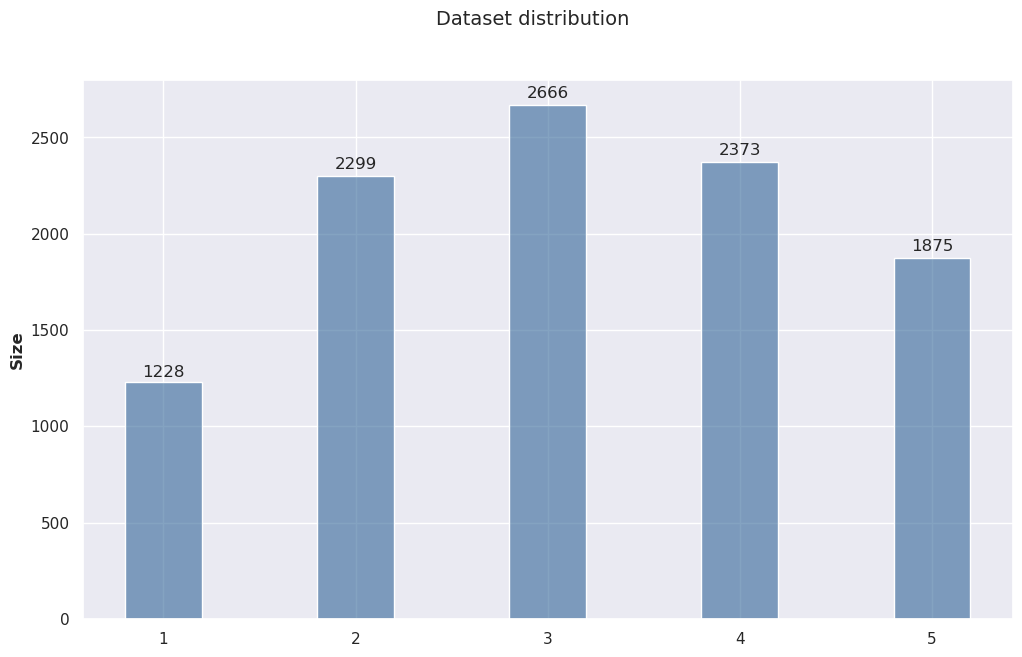

In [46]:
plot_data_distribution(data_distribution)

In [5]:
import os
import numpy as np
from PIL import Image
from PIL import ImageEnhance

In [7]:
train_size, test_size = 0.90, 0.10
data_dir = "train_data"
new_data_dir = "dataset"

In [8]:
# Perform any data cleaning or data preprocessing
def splitt_data(data, data_path):
    data_partition = ['train', 'test']
    _, subdirs, _ = [subdir for subdir in next(os.walk(data))]

    for partition in data_partition:

        if not os.path.isdir(os.path.join(data_path, partition)):
            os.mkdir(os.path.join(data_path, partition))

    for subdir in subdirs:

        subdir_path = os.path.join(data, subdir)
        images = os.listdir(subdir_path)
        np.random.shuffle(images)

        train_images, test_images = np.split(np.array(images), 
                                                             [
                                                                int(len(images) * (1 - test_size))
                                                                  ])
        train_images = [os.path.join(subdir_path, image) for image in train_images.tolist()]
        test_images = [os.path.join(subdir_path, image) for image in test_images.tolist()]
        
        train = {"train": train_images, "test": test_images}
        print(f"Total image for {subdir_path}: ", len(images))
        print(f"Partition: \n Train: {len(train_images)}, Test: {len(test_images)}")
        
        for partition in data_partition:
            
            data_partition_path = os.path.join(data_path, partition)

            if not os.path.isdir(os.path.join(data_partition_path, subdir)):
                os.mkdir(os.path.join(data_partition_path, subdir))
                for train_image in train[partition]:
                    if train_image.split(".")[1] == "jpg":
                        image = Image.open(train_image)
                        enhancer_object = ImageEnhance.Contrast(image)
                        out = enhancer_object.enhance(1.6)
                        enhancer_object = ImageEnhance.Sharpness(out)
                        out = enhancer_object.enhance(1.7)
                        out.save(os.path.join(data_partition_path, subdir, train_image.split("/")[2]))
                    
    return train

In [9]:
tarin = splitt_data(data_dir, new_data_dir)

Total image for train_data/4:  2373
Partition: 
 Train: 2135, Test: 238
Total image for train_data/2:  2299
Partition: 
 Train: 2069, Test: 230
Total image for train_data/1:  1229
Partition: 
 Train: 1106, Test: 123
Total image for train_data/5:  1875
Partition: 
 Train: 1687, Test: 188
Total image for train_data/3:  2667
Partition: 
 Train: 2400, Test: 267


In [6]:
# Upload the data to AWS S3
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = 'Amazon-Empty-Bin-SplitData'
role = sagemaker.get_execution_role()
#inputs = sagemaker_session.upload_data('dataset', bucket=bucket, key_prefix=prefix)
inputs = "s3://sagemaker-us-east-1-213077113041/Amazon-Empty-Bin-SplitData"
print(f"Input spec: {inputs}")

Input spec: s3://sagemaker-us-east-1-213077113041/Amazon-Empty-Bin-SplitData


## Model Training
This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [7]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from sagemaker.pytorch import PyTorch

In [7]:
# Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values
hyperparameters = {"epochs": "20", "batch-size": "32",  "test-batch-size": "32", "lr": "0.001"}

In [8]:
# Create your training estimator
rules = [
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debuger_config = DebuggerHookConfig(
    hook_parameters={'train.save_interval': "1000", 'eval.save_interval': '200'}
)
# The estimator here
estimator = PyTorch(
    role = sagemaker.get_execution_role(),
    instance_count= 1,
    instance_type = "ml.m5.large",
    entry_point = "train.py",
    framework_version = "1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    rules=rules,
    debugger_hook_config=debuger_config
)

In [9]:
# Fit the estimator
estimator.fit({"training": inputs}, wait=True)

2022-07-24 06:37:39 Starting - Starting the training job...
2022-07-24 06:37:55 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-07-24 06:39:34 Downloading - Downloading input data...............
2022-07-24 06:42:11 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-07-24 06:42:00,307 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-07-24 06:42:00,311 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-24 06:42:00,328 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-07-24 06:42:00,339 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-07-24 06:42:

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [8]:
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

[2022-07-26 12:40:44.935 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [8]:
# Create your hyperparameter search space
hp_ranges = {
    'lr': ContinuousParameter(0.001, 0.1),
    'batch_size': CategoricalParameter([8, 16, 32, 64]),
    'epochs': IntegerParameter(2, 10)
}

In [18]:
# Create your training estimator

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

estimator =  PyTorch(
    entry_point = 'train.py',
    role = role,
    py_version='py36',
    framework_version = '1.8',
    instance_count = 1,
    instance_type = 'ml.m5.large',
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config
)

task_tags = [{"Key": "ML Task", "Value": "DGL"}]

objective_metric_name = "Average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hp_ranges,
    metric_definitions,
    tags=task_tags,
    max_jobs=4,
    max_parallel_jobs=3,
    objective_type=objective_type,
)

In [19]:
# Fit your estimator
tuner.fit({"training": inputs})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [20]:
# Find the best hyperparameters
best_estimator = tuner.best_estimator()
best_estimator.hyperparameters()


2022-07-24 16:09:51 Starting - Preparing the instances for training
2022-07-24 16:09:51 Downloading - Downloading input data
2022-07-24 16:09:51 Training - Training image download completed. Training in progress.
2022-07-24 16:09:51 Uploading - Uploading generated training model
2022-07-24 16:09:51 Completed - Training job completed


{'_tuning_objective_metric': '"Average test loss"',
 'batch_size': '"32"',
 'epochs': '2',
 'lr': '0.0021888247230844177',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-07-24-14-25-24-455"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-213077113041/pytorch-training-2022-07-24-14-25-24-455/source/sourcedir.tar.gz"'}

### Model Profiling and Debugging
Use model debugging and profiling to better monitor and debug your model training job.

In [9]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
import boto3
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
import os
import IPython

In [8]:
# Set up debugging and profiling rules and hooks
rules = [
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debuger_config = DebuggerHookConfig(
    hook_parameters={'train.save_interval': "100", 'eval.save_interval': '10'}
)

In [9]:
# Best parameter
hyperparameters = {"epochs": "2", "batch-size": "32",  "test-batch-size": "32", "lr": "0.002"}

In [12]:
# Create and fit an estimator
estimator = PyTorch(
    role = sagemaker.get_execution_role(),
    instance_count= 1,
    instance_type = "ml.m5.large",
    entry_point = "train.py",
    framework_version = "1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    rules=rules,
    debugger_hook_config=debuger_config
)

estimator.fit({"training": inputs}, wait=True)

2022-07-25 12:13:35 Starting - Starting the training job...
2022-07-25 12:14:06 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-07-25 12:15:26 Downloading - Downloading input data.................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-07-25 12:18:14,237 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-07-25 12:18:14,240 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-25 12:18:14,256 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-07-25 12:18:14,264 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-07-25 12:18:14,789 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus install

In [13]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names()

[2022-07-25 13:15:12.483 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-213077113041/pytorch-training-2022-07-25-12-13-35-480/debug-output
[2022-07-25 13:15:13.179 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-07-25 13:15:14.206 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO trial.py:210] Loaded all steps


['NLLLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.10.relu_input_0',
 'layer3.10.relu_input_1',
 'layer3.10.relu_input_2',
 'layer3.11.relu_input_0',
 'layer3.11.relu_input_1',
 'layer3.11.relu_input_2',
 'layer3.12.relu_input_0',
 'layer3.12.relu_input_1',

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


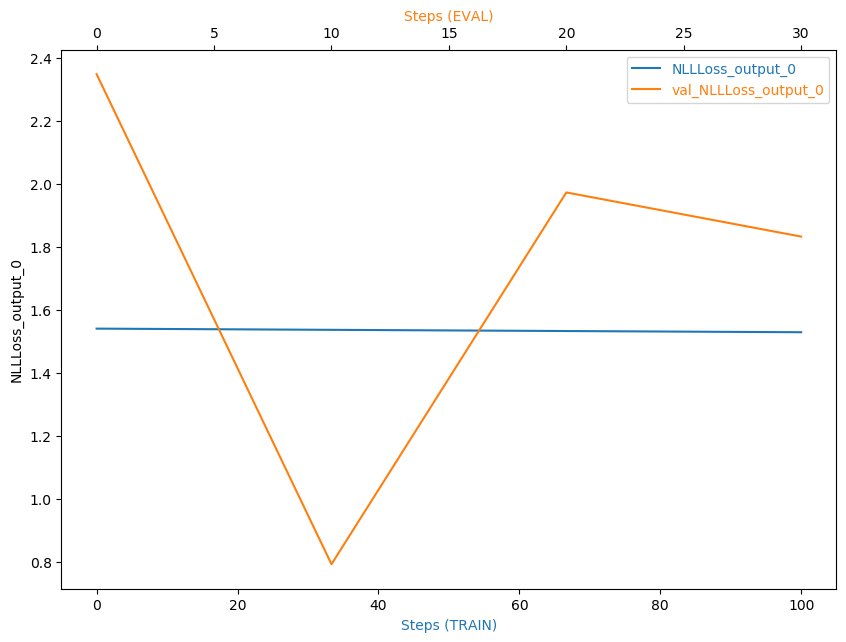

In [16]:
# Plot a debugging output.

# Source AWS sagemaker https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-debugger/pytorch_model_debugging/pytorch_script_change_smdebug.ipynb"
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    

plot_tensor(trial, "NLLLoss_output_0")

Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [17]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
!aws s3 ls {rule_output_path} --recursive

2022-07-25 13:11:25     375282 pytorch-training-2022-07-25-12-13-35-480/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-07-25 13:11:25     223198 pytorch-training-2022-07-25-12-13-35-480/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-07-25 13:11:20        192 pytorch-training-2022-07-25-12-13-35-480/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-07-25 13:11:20        201 pytorch-training-2022-07-25-12-13-35-480/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-07-25 13:11:20       1924 pytorch-training-2022-07-25-12-13-35-480/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-07-25 13:11:20        127 pytorch-training-2022-07-25-12-13-35-480/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-07-25 13:11:20        200 pytorch-training-2022-07-25-12-13-35-480/rule-output/ProfilerReport/profiler-output/profiler-re

In [18]:
!aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-213077113041/pytorch-training-2022-07-25-12-13-35-480/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-213077113041/pytorch-training-2022-07-25-12-13-35-480/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-213077113041/pytorch-training-2022-07-25-12-13-35-480/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-213077113041/pytorch-training-2022-07-25-12-13-35-480/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-213077113041/py

In [19]:
# Display the profiler output
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [33]:
from sagemaker.pytorch.model import PyTorchModel
import json
import numpy as np
import sagemaker

In [27]:
client = boto3.client('sagemaker-runtime')

In [ ]:
predictor = estimator.deploy(1, instance_type)

In [44]:
# Deploy your model to an endpoint
# 
pytorch_model = PyTorchModel(
    model_data='s3://sagemaker-us-east-1-213077113041/pytorch-training-2022-07-25-12-13-35-480/output/model.tar.gz',
    role = sagemaker.get_execution_role(),
    framework_version = "1.8",
    py_version="py36",
    entry_point='inference.py'
)

predictor = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
print(predictor.endpoint_name)

---------!pytorch-inference-2022-07-25-16-24-56-462


In [45]:
# Run an prediction on the endpoint
# https://www.allaboutlean.com/wp-content/uploads/2019/11/Amazon-Bin-Image.jpg
# 
image =  '{"url":"https://www.allaboutlean.com/wp-content/uploads/2019/11/Amazon-Bin-Image.jpg"}'
response = client.invoke_endpoint(EndpointName=predictor.endpoint_name,
                                      ContentType='application/json',
                                      Body=image)
result = json.loads(response['Body'].read().decode())
print(result)

[{'Prediction': '2', 'Score': '37.20412850379944%'}, {'Prediction': '4', 'Score': '22.48728722333908%'}, {'Prediction': '3', 'Score': '21.689707040786743%'}]


In [46]:
# Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

### Cheaper Training and Cost Analysis
Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [13]:
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::213077113041:role/service-role/AmazonSageMaker-ExecutionRole-20220705T190221


In [29]:
# Cost Analysis
client = boto3.client('ce')

response = client.get_cost_and_usage(
        TimePeriod={
            'Start': '2022-07-01',
            'End':  '2022-07-26'
        },
        Granularity='DAILY',
        Metrics=['BlendedCost'],
        GroupBy=[
            {
                'Type': 'TAG',
                'Key': 'Project'
            },
        ]
    )

In [30]:
response

{'GroupDefinitions': [{'Type': 'TAG', 'Key': 'Project'}],
 'ResultsByTime': [{'TimePeriod': {'Start': '2022-07-01', 'End': '2022-07-02'},
   'Total': {},
   'Groups': [{'Keys': ['Project$'],
     'Metrics': {'BlendedCost': {'Amount': '0', 'Unit': 'USD'}}}],
   'Estimated': True},
  {'TimePeriod': {'Start': '2022-07-02', 'End': '2022-07-03'},
   'Total': {'BlendedCost': {'Amount': '0', 'Unit': 'USD'}},
   'Groups': [],
   'Estimated': True},
  {'TimePeriod': {'Start': '2022-07-03', 'End': '2022-07-04'},
   'Total': {'BlendedCost': {'Amount': '0', 'Unit': 'USD'}},
   'Groups': [],
   'Estimated': True},
  {'TimePeriod': {'Start': '2022-07-04', 'End': '2022-07-05'},
   'Total': {'BlendedCost': {'Amount': '0', 'Unit': 'USD'}},
   'Groups': [],
   'Estimated': True},
  {'TimePeriod': {'Start': '2022-07-05', 'End': '2022-07-06'},
   'Total': {},
   'Groups': [{'Keys': ['Project$'],
     'Metrics': {'BlendedCost': {'Amount': '0.1307398113', 'Unit': 'USD'}}}],
   'Estimated': True},
  {'TimePe

In [14]:
rules = [
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debuger_config = DebuggerHookConfig(
    hook_parameters={'train.save_interval': "10", 'eval.save_interval': '1'}
)

hyperparameters = {"epochs": "5", "batch-size": "32",  "test-batch-size": "32", "lr": "0.001"}

In [12]:
use_spot_instances = True
max_run = 3600
max_wait = 7200 if use_spot_instances else None

In [13]:
# Train your model using a spot instance
# Source : https://sagemaker-examples.readthedocs.io/en/latest/sagemaker-python-sdk/managed_spot_training_tensorflow_estimator/managed_spot_training_tensorflow_estimator.html
estimator = PyTorch(
    role = sagemaker.get_execution_role(),
    instance_count= 1,
    instance_type = "ml.m5.large",
    entry_point = "train.py",
    framework_version = "1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    rules=rules,
    debugger_hook_config=debuger_config,
    use_spot_instances=use_spot_instances,
    max_run=max_run,
    max_wait=max_wait
)

estimator.fit({"training": inputs}, wait=True)

2022-07-26 12:46:09 Starting - Starting the training job...
2022-07-26 12:46:37 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-07-26 12:47:58 Downloading - Downloading input data.................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-07-26 12:50:48,397 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-07-26 12:50:48,401 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-26 12:50:48,417 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-07-26 12:50:48,429 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-07-26 12:50:49,164 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus install

Job ended with status 'Stopped' rather than 'Completed'. This could mean the job timed out or stopped early for some other reason: Consider checking whether it completed as you expect.


Training seconds: 3738
Billable seconds: 1422
Managed Spot Training savings: 62.0%


### Multi-Instance Training
Can you train your model on multiple instances?

In [15]:
# Train your model on Multiple Instances
estimator = PyTorch(
    role = sagemaker.get_execution_role(),
    instance_count= 3,
    instance_type = "ml.m5.large",
    entry_point = "train.py",
    framework_version = "1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    rules=rules,
    debugger_hook_config=debuger_config,
    use_spot_instances=use_spot_instances,
    max_run=max_run,
    max_wait=max_wait
)

estimator.fit({"training": inputs}, wait=True)

2022-07-26 13:55:46 Starting - Starting the training job...
2022-07-26 13:56:16 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-07-26 13:57:37 Downloading - Downloading input data...............
2022-07-26 14:00:18 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-07-26 14:00:03,890 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-07-26 14:00:03,893 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-26 14:00:03,910 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-07-26 14:00:03,920 sagemaker_pytorch_container.training INFO     Invoking user training script.
bash: cannot set 

Job ended with status 'Stopped' rather than 'Completed'. This could mean the job timed out or stopped early for some other reason: Consider checking whether it completed as you expect.


Training seconds: 5757
Billable seconds: 2214
Managed Spot Training savings: 61.5%
